## Empirical Reliability Predict demonstration

Demonstration of the empirical reliability predict procedure for a tidal turbine pitch system (a particularly failure critical area).

In [3]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
# set font
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
import classes_funcs as cf

____

#### Component designs

Electro-mechanical pitch system consists of dynamic seal, roller bearing unit, gearbox and electric motor. Each component requires specific design information, influence factors and uncertainty levels.

In [3]:
brg_design_params = {'cw': 0.1,
                 'FR': 20,
                 'n': 2,
                 'd': 750,
                 'd1': 850,
                 'v0': 100,
                'lambda_base': 0.02}
brg_influence_factors = {'Cr':1,
                    'Ct':1,
                    'Csf':1.3,
                    'Cc':1}
brg_inf_factor_uncertainty = {'Cr_unc':0.1,
                        'Ct_unc':0.1,
                        'Csf_unc':0.3,
                        'Cc_unc':0.1,
                         'Cv_unc':0.1,
                         'Ccw_unc':0.1,
                         'lambda_base_unc':0.3}

In [4]:
seal_design_params = {'diam': 22, # inches
                 'Tr': 140,  # rated temp fahrenheit
                 'To': 122,   # op temp fahrenheit
                 'f': 15,   # surface finish is micro_inch RMS
                 'E': 0.7,   # Youngs Modulus MPa
                 'C': 1,    # Contact pressure MPa
                'lambda_base': 0.02}   # failures/yr
seal_influence_factors = {'Cp':0.25,   # fluid pressure
                    'Cq':4.2,   # allowable leakage
                    'Cv':1,    # fluid viscosity
                    'Cn':3.5,     # contaminant influence factor
                        'Cpv':0.5}     # pressure velocity
seal_inf_factor_uncertainty = {'Cp_unc':0.1,
                        'Cq_unc':0.1,
                        'Ch_unc':0.1,
                        'Cf_unc':0.1,
                         'Cv_unc':0.1,
                         'Ct_unc':0.1,
                              'Cn_unc':0.3,
                              'Cpv_unc':0.1,
                         'lambda_base_unc':0.1}

In [5]:
gb_design_params = {'V_ratio': 0.5, # ratio of operating speed to design speed
                 'L_ratio': 0.5,  # ratio of operating load to design load
                 'Ae': 0.3,   # gear misallignment deg
                 'Vl': 150,  # rated lubricant viscosity
                 'V0': 103,   # operating lub viscosity
                'lambda_base': 0.2}   # failures/year
gb_influence_factors = {'Cv':0.53,    # lubrication deviation factor (same as value for brg because its the same lub system)
                    'Cgt':1,
                    'Cgv':1}
gb_inf_factor_uncertainty = {'Cgs_unc':0.1,
                        'Cgp_unc':0.2,
                        'Cga_unc':0.1,
                        'Cv_unc':0.1,
                         'Cgt_unc':0.1,
                         'Cgv_unc':0.1,
                         'lambda_base_unc':0.2}

In [6]:
em_design_params = {'op_time': 0.3, # percentage of time that PS is operating 0.3 = 30%
                 'Vd': 0.05,  # voltage tolerance (how much over rated - 5% according to US Mil)
                 'temp': 50,  # operating temp Celsius
                'lambda_base': (2.7/114.2), # EM overall base failure rate 2.7/mill hrs operating from US Mil handbook (for DC motor)
                   'lambda_win_base':(40/114.2), # winding base failure rate 40/mill hrs operating from US Mil handbook
                   'lambda_bs' :(3.2/114.2),  # brushes failure rate 3.2/mill hrs operating from US Mil handbook
                   'lambda_stat' :(0.001/114.2),  # stator housing failure rate 0.001/mill hrs operating from US Mil handbook
                   'lambda_arm' :(0.0061/114.2)}   # armature shaft failure rate (correction factors all = 1)
em_influence_factors = {'Csf':2,   # service factor for motor base failure rate
                    'Calt':1}   # altitude factor - subsea so is =1
em_inf_factor_uncertainty = {'lambda_win_base_unc':0.2,
                        'lambda_bs_unc':0.1,
                        'lambda_stat_unc':0.1,
                        'lambda_arm_unc':0.1,
                         'lambda_base_unc':0.1}

#### Object creation

Objects are created for each component.

In [7]:
brg1 = cf.bearing(brg_design_params,brg_influence_factors,brg_inf_factor_uncertainty)
brg2 = cf.bearing(brg_design_params,brg_influence_factors,brg_inf_factor_uncertainty)
brg3 = cf.bearing(brg_design_params,brg_influence_factors,brg_inf_factor_uncertainty)
seal1 = cf.seal(seal_design_params,seal_influence_factors,seal_inf_factor_uncertainty)
seal2 = cf.seal(seal_design_params,seal_influence_factors,seal_inf_factor_uncertainty)
seal3 = cf.seal(seal_design_params,seal_influence_factors,seal_inf_factor_uncertainty)
gb = cf.gearbox(gb_design_params,gb_influence_factors,gb_inf_factor_uncertainty)
em = cf.electric_motor(em_design_params,em_influence_factors,em_inf_factor_uncertainty)

#### Failure rate model

In [8]:
def monte_carlo():
    component_list = brg1,brg2,brg3,seal1,seal2,seal3,gb,em    
    rvs = [component_list[i].random_variates(1) for i in range(len(component_list))]   # list comprehension for component rvs
    sum_rvs = [sum(i) for i in zip(*rvs)]  # sum list of lists
    return sum_rvs

In [9]:
ps_rvs = [monte_carlo() for i in range(1,1000)]

#### Priors

In [10]:
# beta and lambda prior distributions

In [11]:
ps_shape,ps_loc,ps_scale=ss.lognorm.fit(ps_rvs)
ps_pdf = ss.lognorm.pdf(ps_rvs,s=ps_shape,loc=ps_loc,scale=ps_scale)

In [12]:
betas = [0.437,0.807,0.815,0.460,0.228,0.573,0.760,0.535,0.257,0.269,0.465,0.397,0.569,0.347,0.412,0.470,0.442,0.675]
beta_shape,beta_loc,beta_scale = ss.lognorm.fit(betas)
beta_rvs = ss.lognorm.rvs(s=beta_shape,scale=beta_scale,loc=beta_loc,size=1000)
beta_pdf = ss.lognorm.pdf(x=beta_rvs,s=beta_shape,scale=beta_scale,loc=beta_loc)

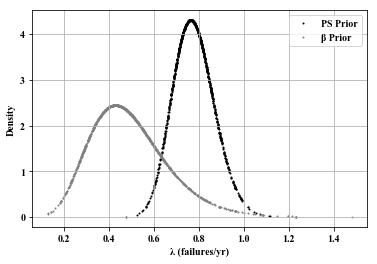

In [13]:
fig,ax = plt.subplots()
_=ax.scatter(ps_rvs,ps_pdf,color='black',s=1,label='PS Prior')
_=ax.scatter(beta_rvs,beta_pdf,color='grey',s=1,label='β Prior')
_=ax.set(ylabel='Density',xlabel='λ (failures/yr)')
_=ax.grid()
_=ax.legend()
#_=plt.savefig(fname='prior_dists')

In [14]:
ps_std = ss.lognorm.std(s=ps_shape,loc=ps_loc,scale=ps_scale)   # std of ps failure rate dist
ps_mean = ss.lognorm.mean(s=ps_shape,loc=ps_loc,scale=ps_scale)  # expected value of ps failure rate dist
beta_std = ss.lognorm.std(s=beta_shape,scale=beta_scale,loc=beta_loc)   # std of ps failure rate dist
beta_mean = ss.lognorm.mean(s=beta_shape,scale=beta_scale,loc=beta_loc)  # expected value of ps failure rate dist

In [29]:
ps_mean,beta_mean

(0.777462399199102, 0.4956674505258396)

#### Likelihood

In [82]:
wt_data = ss.weibull_min.rvs(c=0.61, loc=0, scale=0.5, size=10)  # likelihood (observed data eg wind failure data)
# fit dist to observed data
wt_shape,wt_loc,wt_scale = ss.weibull_min.fit(wt_data,loc=0)
wt_rvs = ss.weibull_min.rvs(c=wt_shape,scale=wt_scale, loc=wt_loc,size=1000)
wt_sf = ss.weibull_min.sf(wt_rvs,c=wt_shape,loc=0, scale=wt_scale)

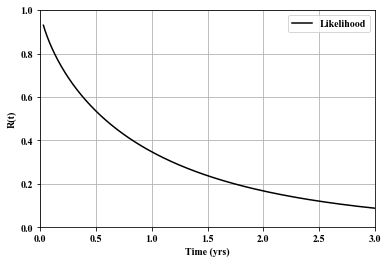

In [94]:
fig,ax = plt.subplots()
#_=ax.scatter(np.sort(wt_data), range(len(wt_data)), lw=1,c='r',s=10,label='Failures')
_=ax.plot(np.sort(wt_rvs), np.sort(-wt_sf)*-1,label='Likelihood',c='k')
_=ax.set(xlim=[0,3],ylim=[0,1],ylabel='R(t)',xlabel='Time (yrs)')
_=ax.grid()
_=ax.legend()
_=plt.savefig(fname='likelihood_wbl')

#### Bayesian update

In [74]:
with pm.Model() as model:
    rate = pm.Lognormal('Rate',mu=ps_mean,sd=ps_std)
    shape = pm.Lognormal('Shape',mu=beta_mean,sd=beta_std)
    obs = pm.Weibull('obs',alpha=shape,beta=1/rate,observed=wt_data)   # beta = scale = 1/rate, alpha = shape
    trace = pm.sample(10000,live_plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Shape, Rate]
Sampling 2 chains: 100%|█████████████████████████████████████████████████████| 21000/21000 [01:04<00:00, 326.37draws/s]


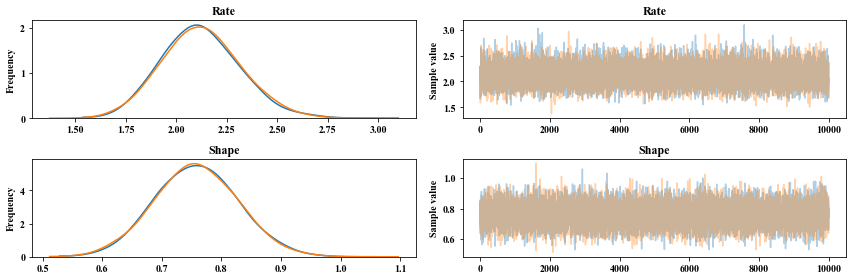

In [75]:
_=pm.traceplot(trace)

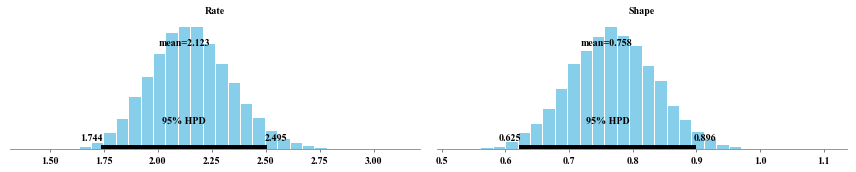

In [97]:
_=pm.plot_posterior(trace)
#12plt.savefig(fname='posteriors')

In [77]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Rate,2.123359,0.192564,0.001308,1.744341,2.495182,18083.579548,1.000065
Shape,0.758406,0.069154,0.000442,0.625171,0.895780,18289.385405,0.999980


In [23]:
pm.waic(trace,model)

WAIC_r(WAIC=925.2001816833246, WAIC_se=110.57111871389701, p_WAIC=1.7626497562168526, var_warn=0)

In [24]:
pm.find_MAP(model=model)

logp = -474.64, ||grad|| = 0.15484: 100%|█████████████████████████████████████████████| 14/14 [00:00<00:00, 466.22it/s]


{'Rate_log__': array(0.68300139),
 'Shape_log__': array(-0.48888157),
 'Rate': array(1.97981101),
 'Shape': array(0.61331196)}

#### Updated Reliability

In [25]:
# use updated parameter values to estimate reliability

In [42]:
rel_update_rvs = ss.weibull_min.rvs(size=1000,c=0.61,scale=1/1.97,loc=0)   # rvs generation with new parameter values
upd_shape,upd_scale,upd_loc = ss.weibull_min.fit(rel_update_rvs)     # weibull fit
upd_sf = ss.weibull_min.sf(rel_update_rvs,upd_shape,upd_scale,upd_loc)

In [43]:
prior_rel_rvs = ss.weibull_min.rvs(c=beta_mean,scale=1/ps_mean,loc=0,size=1000)
prior_rel_sf = ss.weibull_min.sf(prior_rel_rvs,c=beta_mean,scale=1/ps_mean,loc=0)

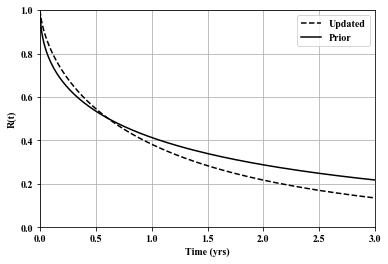

In [96]:
fig,ax = plt.subplots()
_=ax.plot(np.sort(rel_update_rvs), np.sort(-upd_sf)*-1,label='Updated',ls='--',c='k')
_=ax.plot(np.sort(prior_rel_rvs),np.sort(-prior_rel_sf)*-1,label='Prior',c='k')
_=ax.set(xlim=[0,3],ylim=[0,1],ylabel='R(t)',xlabel='Time (yrs)')
_=ax.grid()
_=ax.legend()
#_=plt.savefig(fname='updated_reliability')